In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(False) 
tf.data.experimental.enable_debug_mode()
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, RandomZoom
from sklearn.model_selection import StratifiedKFold
# import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

In [2]:
def create_dataset(directory, img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    data = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return data

In [4]:
img_size = (224, 224)
batch_size = 32
train_dir = "train_limited"  
val_dir = "Val" 
num_folds=5

In [7]:
dataset = create_dataset(train_dir, img_size, batch_size)
val_set = create_dataset(val_dir, img_size, batch_size)

Found 17240 images belonging to 14 classes.
Found 3660 images belonging to 14 classes.


In [10]:
# Load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=img_size)
    img = img_to_array(img)
    img /= 255.0
    return img

In [15]:
class_names = list(dataset.class_indices.keys())

In [18]:
class_names

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Chickenpox',
 'Cowpox',
 'Dermatofibroma',
 'HFMD',
 'Healthy',
 'Measles',
 'Melanocytic nevi',
 'Melanoma',
 'Monkeypox',
 'Squamous cell carcinoma',
 'Vascular lesions']

In [19]:
num_classes = len(class_names)

In [20]:
num_classes

14

In [22]:
input_shape = dataset.image_shape

In [23]:
input_shape

(224, 224, 3)

In [25]:
# X[1]

In [26]:

# Callbacks
checkpoint_callback = ModelCheckpoint(
    'best_coustm_model2.2.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)

# Combine all in a list
callbacks = [checkpoint_callback, early_stopping, reduce_lr]


In [27]:
def build_model():
    input_shape=(224, 224, 3)
    model= models.Sequential()
    model.add(Input(shape=input_shape))

    # # Data Augmentation Layers
    # model.add(RandomFlip("horizontal"))
    # model.add(RandomRotation(0.1))
    # model.add(RandomZoom(0.1))
    
    #Convolutional Layer
    model.add(Conv2D(32,(3,3),padding = "same",activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2),padding="same"))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64,(3,3),padding = "same",activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2),padding="same"))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128,(3,3),padding = "same",activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2),padding="same"))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), padding="same"))
    model.add(Dropout(0.4))

    
    # Flatten
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(256,activation="relu"))
    #Out put layer
    model.add(Dense(num_classes, activation="softmax"))
     # Compile the model
    optimizer=Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary()
    return model

In [45]:
sdmodel=build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,239,246 (50.50 MB)

 Trainable params: 13,238,286 (50.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
history = sdmodel.fit(
    dataset,
    validation_data=val_set,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

c:\Users\ESHWAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2453 - loss: 2.5933
Epoch 1: val_loss improved from inf to 12.19886, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 846s 2s/step - accuracy: 0.2454 - loss: 2.5925 - val_accuracy: 0.0959 - val_loss: 12.1989 - learning_rate: 1.0000e-04
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3698 - loss: 1.8119
Epoch 2: val_loss improved from 12.19886 to 5.86538, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - accuracy: 0.3698 - loss: 1.8118 - val_accuracy: 0.1932 - val_loss: 5.8654 - learning_rate: 1.0000e-04
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4151 - loss: 1.6669
Epoch 3: val_loss did not improve from 5.86538
539/539 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - accuracy: 0.4151 - loss: 1.6669 - val_accuracy: 0.1276 - val_loss: 7.5329 - learning_rate: 1.0000e-04
Epoch 4/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4392 - loss: 1.5707
Epoch 4: val_loss improved from 5.86538 to 5.69589, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.4392 - loss: 1.5707 - val_accuracy: 0.1410 - val_loss: 5.6959 - learning_rate: 1.0000e-04
Epoch 5/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4764 - loss: 1.4646
Epoch 5: val_loss improved from 5.69589 to 3.36407, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 807s 1s/step - accuracy: 0.4764 - loss: 1.4646 - val_accuracy: 0.2358 - val_loss: 3.3641 - learning_rate: 1.0000e-04
Epoch 6/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4942 - loss: 1.4043
Epoch 6: val_loss did not improve from 3.36407
539/539 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.4942 - loss: 1.4043 - val_accuracy: 0.1822 - val_loss: 4.6216 - learning_rate: 1.0000e-04
Epoch 7/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5112 - loss: 1.3361
Epoch 7: val_loss improved from 3.36407 to 3.31436, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.5113 - loss: 1.3361 - val_accuracy: 0.2792 - val_loss: 3.3144 - learning_rate: 1.0000e-04
Epoch 8/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5345 - loss: 1.2749
Epoch 8: val_loss improved from 3.31436 to 2.61927, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.5345 - loss: 1.2749 - val_accuracy: 0.3495 - val_loss: 2.6193 - learning_rate: 1.0000e-04
Epoch 9/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5529 - loss: 1.2411
Epoch 9: val_loss improved from 2.61927 to 2.20700, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.5529 - loss: 1.2411 - val_accuracy: 0.4355 - val_loss: 2.2070 - learning_rate: 1.0000e-04
Epoch 10/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5701 - loss: 1.1874
Epoch 10: val_loss improved from 2.20700 to 1.86694, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.5701 - loss: 1.1874 - val_accuracy: 0.4579 - val_loss: 1.8669 - learning_rate: 1.0000e-04
Epoch 11/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5802 - loss: 1.1442
Epoch 11: val_loss did not improve from 1.86694
539/539 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.5802 - loss: 1.1442 - val_accuracy: 0.3926 - val_loss: 2.7118 - learning_rate: 1.0000e-04
Epoch 12/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5885 - loss: 1.1185
Epoch 12: val_loss improved from 1.86694 to 1.82757, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - accuracy: 0.5885 - loss: 1.1185 - val_accuracy: 0.4667 - val_loss: 1.8276 - learning_rate: 1.0000e-04
Epoch 13/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6061 - loss: 1.0646
Epoch 13: val_loss improved from 1.82757 to 1.65416, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.6061 - loss: 1.0646 - val_accuracy: 0.4645 - val_loss: 1.6542 - learning_rate: 1.0000e-04
Epoch 14/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6199 - loss: 1.0441
Epoch 14: val_loss improved from 1.65416 to 1.53106, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.6199 - loss: 1.0441 - val_accuracy: 0.5254 - val_loss: 1.5311 - learning_rate: 1.0000e-04
Epoch 15/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6255 - loss: 1.0053
Epoch 15: val_loss improved from 1.53106 to 1.34389, saving model to best_coustm_model2.2.h5


539/539 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.6255 - loss: 1.0053 - val_accuracy: 0.5770 - val_loss: 1.3439 - learning_rate: 1.0000e-04
Epoch 16/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6315 - loss: 0.9897
Epoch 16: val_loss did not improve from 1.34389
539/539 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.6315 - loss: 0.9897 - val_accuracy: 0.4877 - val_loss: 1.7967 - learning_rate: 1.0000e-04
Epoch 17/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6568 - loss: 0.9276
Epoch 17: val_loss did not improve from 1.34389

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
539/539 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.6567 - loss: 0.9277 - val_accuracy: 0.4456 - val_loss: 2.5255 - learning_rate: 1.0000e-04
Epoch 18/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6752 - loss: 0.8724
Epoch 18: val_loss did not improve from 1.34389
539/539 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.6752 - loss: 0.8724 - val

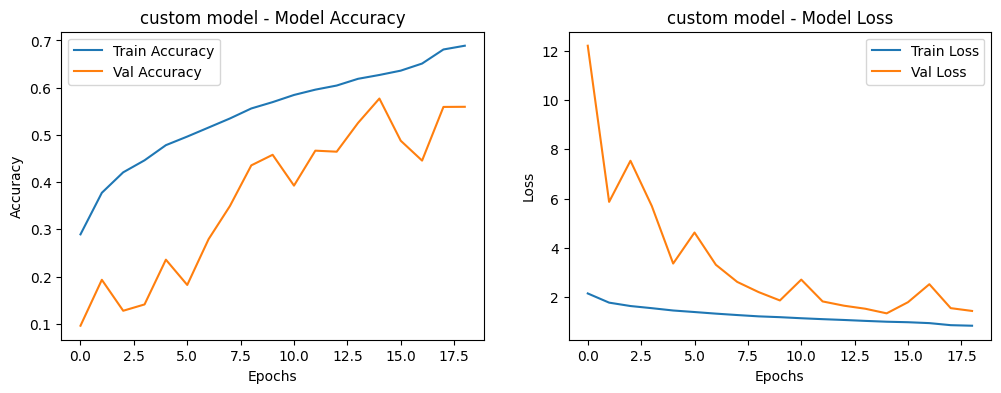

In [48]:
# Plot Training History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{title} - Model Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{title} - Model Loss')

    plt.show()

# Plot Training Results for EfficientNetB0
plot_history(history, "custom model")

In [ ]:
# Load external validation set
val_datagen = ImageDataGenerator(rescale=1./255)
test_final_generator = val_datagen.flow_from_directory(
    "test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3675 images belonging to 14 classes.


In [50]:
loss, accuracy = sdmodel.evaluate(test_final_generator, verbose=1)
print(f"✅ Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 441ms/step - accuracy: 0.4907 - loss: 1.6602
✅ Test Loss: 1.3662, Accuracy: 0.5605


In [1]:
from tensorflow.keras.models import load_model
sdm=load_model("best_coustm_model2.2.h5")

In [2]:
import matplotlib.pyplot as plt

In [3]:
class_names=['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Chickenpox',
 'Cowpox',
 'Dermatofibroma',
 'HFMD',
 'Healthy',
 'Measles',
 'Melanocytic nevi',
 'Melanoma',
 'Monkeypox',
 'Squamous cell carcinoma',
 'Vascular lesions']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


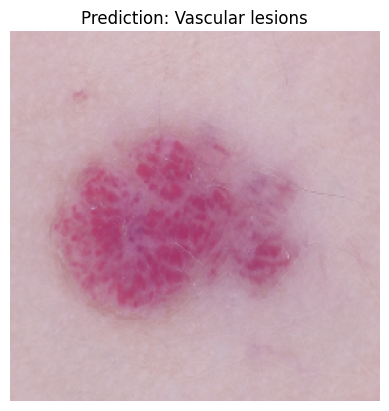

In [5]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_skin_cancer(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand for batch dimension

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = class_names[class_index]

    plt.imshow(img)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

# Test the model with an image
predict_skin_cancer("test/Vascular lesions/ISIC_0026876.jpg", sdm)


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='test',
    target_size=(224, 224),    
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)


Found 3674 images belonging to 14 classes.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve,auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K

In [4]:
model = load_model('best_coustm_model2.2.h5')

c:\Users\ESHWAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step


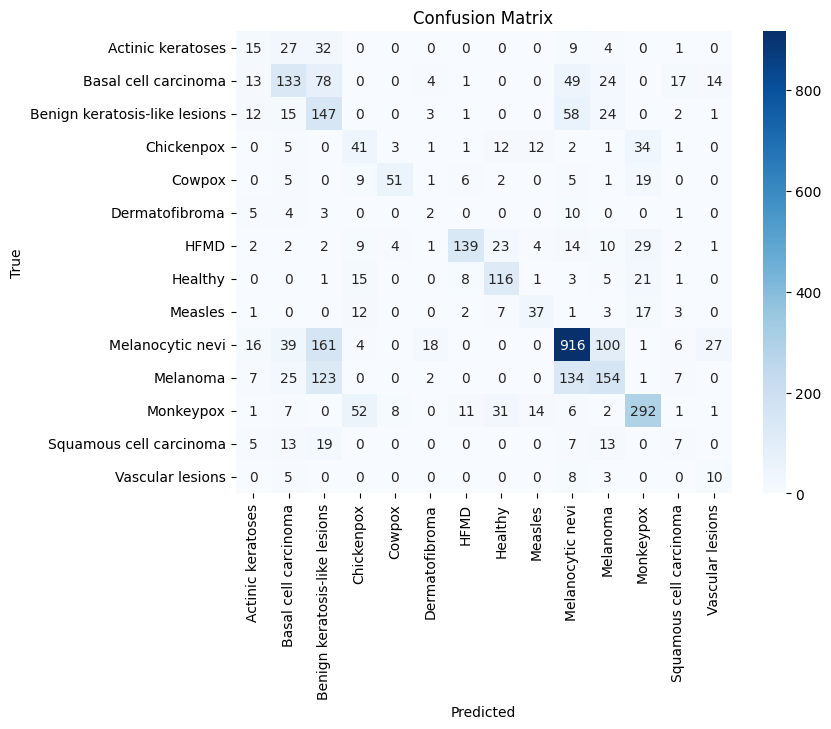

In [5]:
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
class_names = list(test_generator.class_indices.keys())
print("Class names:", class_names)
print("Class indices:", test_generator.class_indices)

Class names: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}


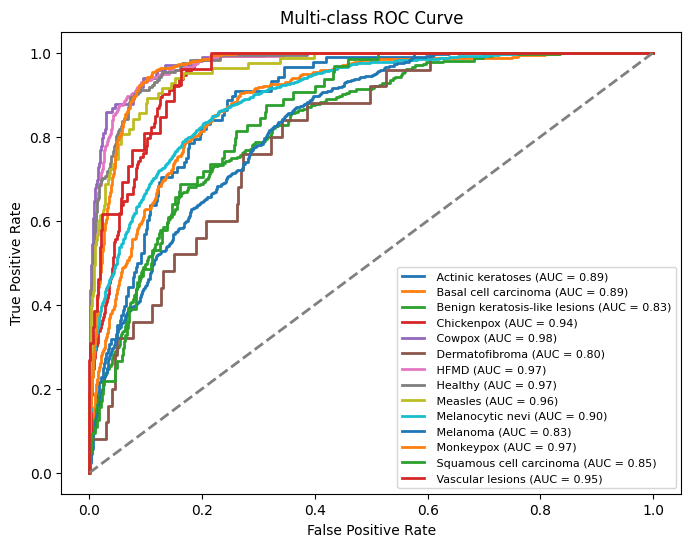

In [8]:
true_classes = test_generator.classes
n_classes = len(test_generator.class_indices)
true_classes_bin = label_binarize(true_classes, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right', fontsize=8)
plt.show()

In [10]:
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print("\nClassification Report:")
print(report_df)


Classification Report:
                               precision    recall  f1-score      support
Actinic keratoses               0.194805  0.170455  0.181818    88.000000
Basal cell carcinoma            0.475000  0.399399  0.433931   333.000000
Benign keratosis-like lesions   0.259717  0.558935  0.354644   263.000000
Chickenpox                      0.288732  0.362832  0.321569   113.000000
Cowpox                          0.772727  0.515152  0.618182    99.000000
Dermatofibroma                  0.062500  0.080000  0.070175    25.000000
HFMD                            0.822485  0.574380  0.676399   242.000000
Healthy                         0.607330  0.678363  0.640884   171.000000
Measles                         0.544118  0.445783  0.490066    83.000000
Melanocytic nevi                0.749591  0.711180  0.729880  1288.000000
Melanoma                        0.447674  0.339956  0.386449   453.000000
Monkeypox                       0.705314  0.685446  0.695238   426.000000
Squamous cell 

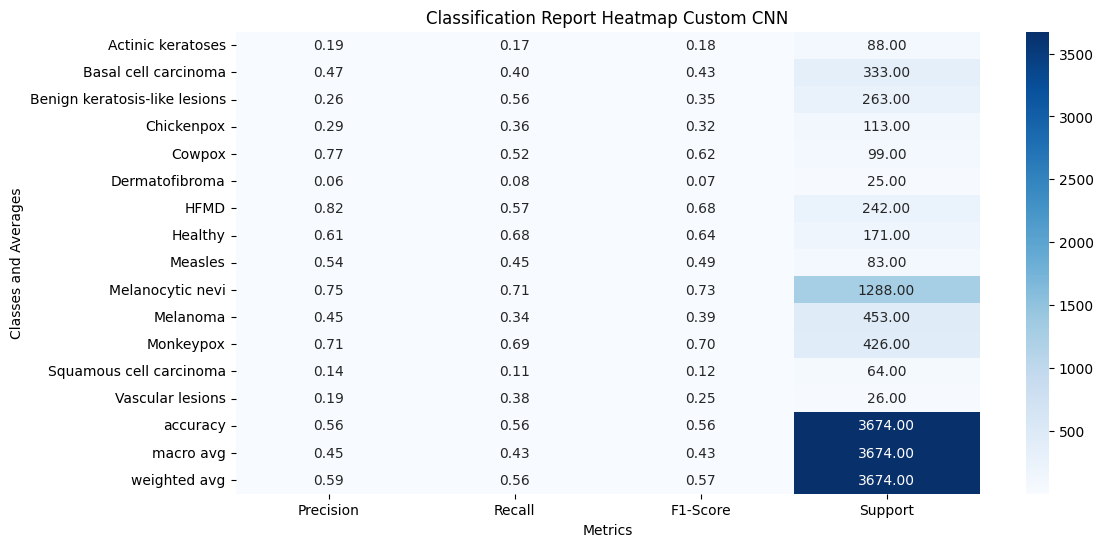

In [11]:
metrics_df = report_df[['precision', 'recall', 'f1-score', 'support']].iloc[:-3] 

accuracy = report_df.loc['accuracy', 'precision']
macro_avg = report_df.loc['macro avg', ['precision', 'recall', 'f1-score', 'support']]
weighted_avg = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score', 'support']]


metrics_df.loc['accuracy'] = [accuracy, accuracy, accuracy, 3674]  
metrics_df.loc['macro avg'] = macro_avg  
metrics_df.loc['weighted avg'] = weighted_avg  

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", cbar=True, fmt=".2f", 
            xticklabels=['Precision', 'Recall', 'F1-Score', 'Support'], 
            yticklabels=metrics_df.index)
plt.title("Classification Report Heatmap Custom CNN")
plt.xlabel("Metrics")
plt.ylabel("Classes and Averages")
plt.show()

In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from collections import defaultdict

def evaluate_model_on_test_folder(model_path, test_folder, img_height=224, img_width=224):
    model = load_model(model_path)
    class_names = sorted(os.listdir(test_folder))
    correct_counts = defaultdict(int)
    total_counts = defaultdict(int)

    # Supported image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    for class_name in class_names:
        class_path = os.path.join(test_folder, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Skip non-image files
            if not any(img_file.lower().endswith(ext) for ext in valid_extensions):
                continue

            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = img_array / 255.0

                # Predict
                predictions = model.predict(img_array, verbose=0)
                predicted_index = np.argmax(predictions[0])
                predicted_label = class_names[predicted_index]

                total_counts[class_name] += 1
                if predicted_label == class_name:
                    correct_counts[class_name] += 1

                # Print the actual and predicted label
                print(f"Actual: {class_name} - Predicted: {predicted_label}")

            except Exception as e:
                print(f"Skipping file {img_path}: {e}")

    print("\nPrediction Summary:")
    for class_name in class_names:
        print(f"Class: {class_name} - Correct Predictions: {correct_counts[class_name]} / {total_counts[class_name]}")

    total_correct = sum(correct_counts.values())
    total_samples = sum(total_counts.values())
    overall_accuracy = total_correct / total_samples * 100 if total_samples > 0 else 0
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")


In [2]:
evaluate_model_on_test_folder(
    model_path='best_coustm_model2.2.h5',
    test_folder='test',
    img_height=224,
    img_width=224
)


Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Melanocytic nevi
Actual: Actinic keratoses - Predicted: Melanoma
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Melanocytic nevi
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Benign keratosis-like lesions
Actual: Actinic keratoses - Predicted: Basal cell carcinoma
Actual: Actinic keratoses - Predicted: Benign ke